# Relaxation Method for Solving Laplace's Equation
**Physics 321 BONUS Computational Assignment**

In this notebook, we compute the electric potential inside a grounded square box with anarbitrary volatges using the relaxation method. We then:
- Plot the heat-map of the potential and the electrode pattern.
- Iterate to update the potential until convergence.
- Monitor convergence using mean and maximum change per iteration.
- Continue iterating until a specified tolerance (1 mV) is met or a 30-second time limit is reached.
- Create a contour plot to visualize equipotentials.
- Discuss an analytical solution (from Griffiths' textbook) for comparison and note qualitative differences.


In [1]:
# Inital Imports (Code Given)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For timing (used later if we want a time-based cutoff)
import time


In [2]:
# Grid size
NX, NY = 100, 100

# Create a 100 x 100 grid for the potential (all zeros initially)
grid_0 = np.zeros((NX, NY))

# Create an array marking which points are fixed (True) vs. free (False)
electrodes = np.zeros((NX, NY), dtype=bool)

# Mark the boundary as fixed (always 0 V)
electrodes[0, :]   = True
electrodes[-1, :]  = True
electrodes[:, 0]   = True
electrodes[:, -1]  = True

# Define arbitrary fixed potentials using a list of (row, col, potential) tuples.
fixed_points = [
    # x,y,potential
    (10, 40, 20),  # fixed point at (10,40) with 20 V
    (10, 50, 40),  # fixed point at (10,50) with 40 V
    (50, 80, 60),  # fixed point at (50,80) with 60 V
    (70, 60, 20),  # fixed point at (70,60) with 20 V
    (90, 40, 20),  # fixed point at (90,40) with 20 V
    (10, 20, 60),  # fixed point at (10,20) with 60 V
    (30, 80, 80),  # fixed point at (30,80) with 80 V
    (50, 60, 80),  # fixed point at (50,60) with 80 V
    (70, 40, 100), # fixed point at (70,40) with 100 V
    (90, 20, 20)   # fixed point at (90,20) with 20 V
]

# Apply the fixed potentials and mark them in the electrodes array
for i, j, potential in fixed_points:
    grid_0[i, j] = potential
    electrodes[i, j] = True

# Optionally, the original electrode at (49,49):
grid_0[49, 49] = 100.0
electrodes[49, 49] = True

# For verification, print the number of fixed points (should be at least the boundaries + these points)
print("Total fixed points (True in electrodes):", np.sum(electrodes))


Total fixed points (True in electrodes): 407


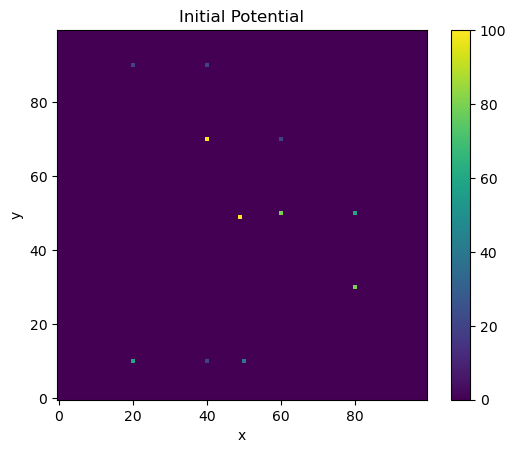

In [3]:
# "Heat-map" plto of the initial potential using matplotlib’s (CODE GIVEN)
fig0, ax0 = plt.subplots()

plot0 = ax0.imshow(grid_0,
                   interpolation="none", 
                   origin="lower",
                   aspect="equal")

#interpolation="none" is the most important. It tells the program to only show the actual values in
#the grid and not to interpolate between points. The plot will likely have much more than 100 × 100
#pixels. Without this option, it would calculate intermediate values for the pixels between our actual
#data points. We don’t want this.

#origin="lower" tells the program where the origin of our plot is. Our first plot is quite symmetric
#so it’s not important, but later  will have more complex arrangements of fixed potentials and 
#don’t want the image flipped.

#aspect="equal" tells the plot to be square, because we want the 100 × 100 grid to represent a square
#region of space with uniform grid points.

fig0.colorbar(plot0)  # add a colorbar scale  i.e. it tells  which colors
#correspond to which values.

ax0.set_xlabel("x")
ax0.set_ylabel("y")
ax0.set_title("Initial Potential")
plt.show()


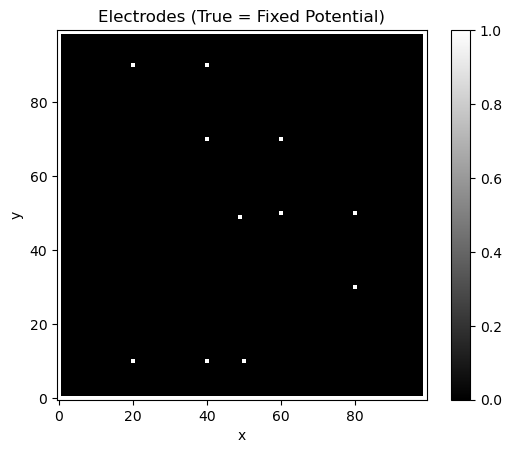

In [4]:
#Add a similar plot showing electrode pattern, using option cmap="gray" to get gray scale.

fig1, ax1 = plt.subplots()

plot1 = ax1.imshow(electrodes,
                   interpolation="none",
                   origin="lower",
                   aspect="equal",
                   cmap="gray")
fig1.colorbar(plot1)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Electrodes (True = Fixed Potential)")
plt.show()


In [5]:
# Make two working arrays from grid_0
grid_1 = np.copy(grid_0)
grid_2 = np.copy(grid_0)


(Why do we use numpy.copy instead of just saying grid 1 = grid 0?)


In [6]:
def average_neighbors(grid_in, grid_out=None):
    """
    Replace each free (non-electrode) point with
    the average of its four nearest neighbors.

    Parameters
    ----------
    grid_in : numpy array
        The input potential on the grid.
    grid_out : numpy array, optional
        If provided, the result is stored here.
        Otherwise, a copy is created.

    Returns
    -------
    grid_out : numpy array
        The updated potential array after one relaxation step.
    """
    if grid_out is None:
        grid_out = np.copy(grid_in)
    
    # Use an nditer to loop over grid_out, but read from grid_in
    it = np.nditer(grid_out, flags=['multi_index'], op_flags=['writeonly'])
    for val_out in it:
        i_x, i_y = it.multi_index
        # Only update if not an electrode
        if not electrodes[i_x, i_y]:
            # 4-neighbor average from grid_in
            val = (grid_in[i_x+1, i_y] + 
                   grid_in[i_x-1, i_y] +
                   grid_in[i_x, i_y+1] + 
                   grid_in[i_x, i_y-1]) / 4.0
            val_out[...] = val # Special syntax to fill grid_out using nditer
        else:
            # Keep electrode points unchanged
            val_out[...] = grid_in[i_x, i_y]
    
    return grid_out


In [7]:
# Create a for loop that, at each iteration

n_iterations = 100

# To monitor how much the solution changes each iteration:
mean_deltas = []
max_deltas  = []

for i in range(n_iterations):
    # grid_2 <- average_neighbors(grid_1)
    grid_2 = average_neighbors(grid_1, grid_2)
    
    # Compute the difference
    delta = np.abs(grid_2 - grid_1)
    mean_deltas.append(np.mean(delta))
    max_deltas.append(np.max(delta))
    
    # Now swap, so the next iteration uses the new values
    grid_1, grid_2 = grid_2, grid_1

# After the loop, grid_1 has the updated potential.
final_grid = grid_1


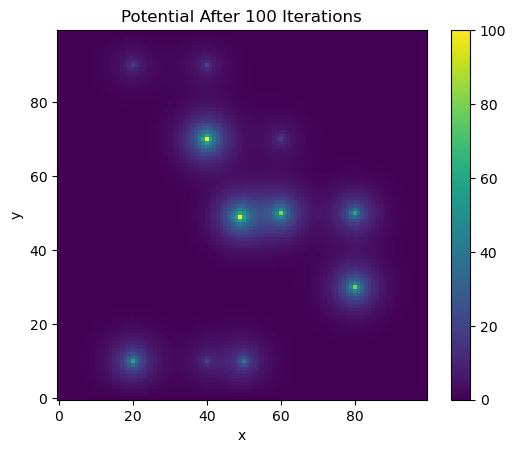

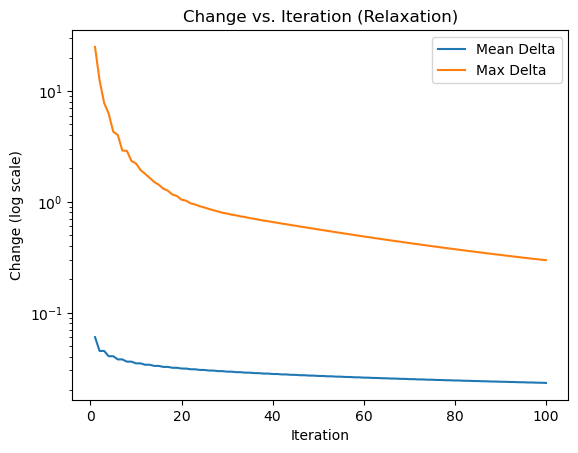

In [8]:
# Plot the final potential after 100 iterations
fig2, ax2 = plt.subplots()

plot2 = ax2.imshow(final_grid,
                   interpolation="none",
                   origin="lower",
                   aspect="equal")
fig2.colorbar(plot2)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title(f"Potential After {n_iterations} Iterations")
plt.show()

# Plot delta vs iteration
iterations = np.arange(1, n_iterations+1)

plt.figure()
plt.plot(iterations, mean_deltas, label='Mean Delta')
plt.plot(iterations, max_deltas, label='Max Delta')
plt.yscale('log')  # log scale on y-axis
plt.xlabel('Iteration')
plt.ylabel('Change (log scale)')
plt.title('Change vs. Iteration (Relaxation)')
plt.legend()
plt.show()


In [9]:
tolerance = 1e-3   # 1 mV
time_limit = 30.0  # 30 seconds

# Re-initialize
grid_1 = np.copy(grid_0)
grid_2 = np.copy(grid_0)

mean_deltas_2 = []
max_deltas_2  = []

start_time = time.perf_counter()
i_iter = 0

while True:
    i_iter += 1
    grid_2 = average_neighbors(grid_1, grid_2)
    
    delta = np.abs(grid_2 - grid_1)
    mu_d = np.mean(delta)
    mx_d = np.max(delta)
    
    mean_deltas_2.append(mu_d)
    max_deltas_2.append(mx_d)
    
    # Swap
    grid_1, grid_2 = grid_2, grid_1
    
    # Check tolerance
    if mu_d < tolerance:
        print(f"Reached tolerance {tolerance} V after {i_iter} iterations.")
        break
    
    # Check time
    elapsed = time.perf_counter() - start_time
    if elapsed > time_limit:
        print(f"Time limit of {time_limit} s exceeded after {i_iter} iterations.")
        break
    
    # Optional: print status every 100 iterations
    if i_iter % 100 == 0:
        print(f"Iteration = {i_iter}, Mean Δ = {mu_d:.4g}, Max Δ = {mx_d:.4g}, elapsed={elapsed:.2f}s")

final_grid_2 = grid_1
print(f"Final iteration count: {i_iter}")


Iteration = 100, Mean Δ = 0.02314, Max Δ = 0.2969, elapsed=2.86s
Iteration = 200, Mean Δ = 0.01912, Max Δ = 0.1608, elapsed=5.74s
Iteration = 300, Mean Δ = 0.01648, Max Δ = 0.1208, elapsed=8.61s
Iteration = 400, Mean Δ = 0.01445, Max Δ = 0.09345, elapsed=11.50s
Iteration = 500, Mean Δ = 0.01278, Max Δ = 0.07407, elapsed=14.38s
Iteration = 600, Mean Δ = 0.01137, Max Δ = 0.06133, elapsed=17.25s
Iteration = 700, Mean Δ = 0.01014, Max Δ = 0.05327, elapsed=20.15s
Iteration = 800, Mean Δ = 0.00907, Max Δ = 0.0468, elapsed=22.99s
Iteration = 900, Mean Δ = 0.00812, Max Δ = 0.04145, elapsed=25.79s
Iteration = 1000, Mean Δ = 0.007277, Max Δ = 0.0369, elapsed=28.63s
Time limit of 30.0 s exceeded after 1049 iterations.
Final iteration count: 1049


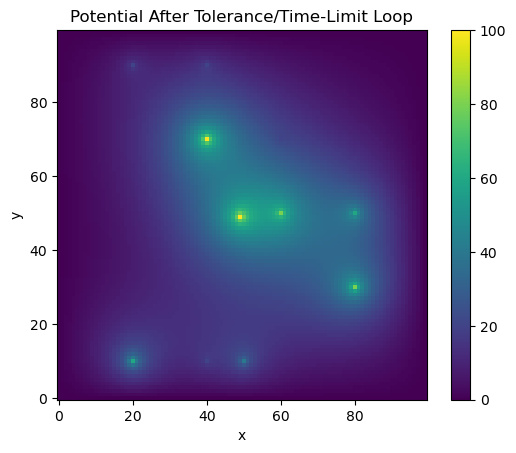

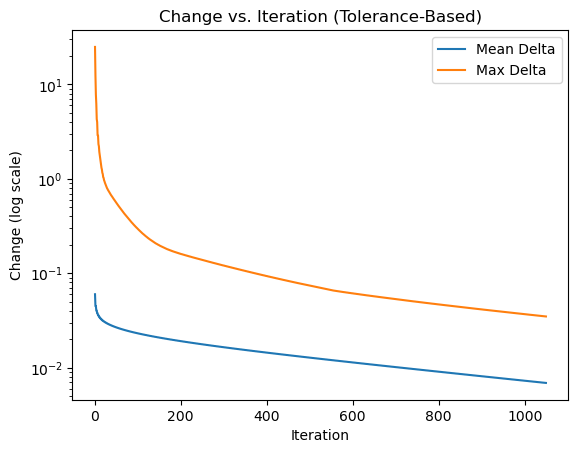

In [10]:
fig4, ax4 = plt.subplots()
plot4 = ax4.imshow(final_grid_2,
                   interpolation='none',
                   origin='lower',
                   aspect='equal')
fig4.colorbar(plot4)
ax4.set_title("Potential After Tolerance/Time-Limit Loop")
ax4.set_xlabel('x')
ax4.set_ylabel('y')
plt.show()

plt.figure()
iterations_2 = np.arange(1, len(mean_deltas_2)+1)
plt.plot(iterations_2, mean_deltas_2, label='Mean Delta')
plt.plot(iterations_2, max_deltas_2, label='Max Delta')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Change (log scale)')
plt.title('Change vs. Iteration (Tolerance-Based)')
plt.legend()
plt.show()


What do  notice about the shape of the delta plot? Is the slope
linear (on a log scale)?


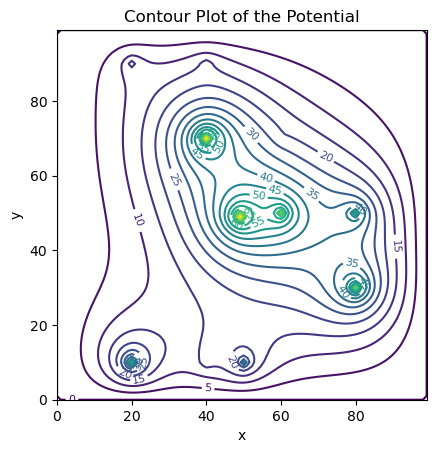

In [11]:
#Contour Plot 

# We'll use np.indices to get Y,X arrays
Y, X = np.indices(final_grid_2.shape)

fig5 = plt.figure()
ax5 = fig5.add_subplot(aspect='equal')

# Plot 20 contour levels between the min and max
cs = ax5.contour(X, Y, final_grid_2, levels=20)
ax5.clabel(cs, inline=1, fontsize=8)  # optional: label the contours
ax5.set_title("Contour Plot of the Potential")
ax5.set_xlabel("x")
ax5.set_ylabel("y")
plt.show()
